# Genshin YOLO detection Training Notebook

In this notebook, you will see how we train the Ultralytics YOLOv11 model to detect the most important elements visible in Genshin Impact. _(This notebook is designed for Google Colab but can be run anywhere with some adjustments)_

**First, let's verify that we have a GPU active**

In [1]:
!nvidia-smi

Mon Mar 31 17:13:47 2025       
+-----------------------------------------------------------------------------------------+
| NVIDIA-SMI 550.54.15              Driver Version: 550.54.15      CUDA Version: 12.4     |
|-----------------------------------------+------------------------+----------------------+
| GPU  Name                 Persistence-M | Bus-Id          Disp.A | Volatile Uncorr. ECC |
| Fan  Temp   Perf          Pwr:Usage/Cap |           Memory-Usage | GPU-Util  Compute M. |
|                                         |                        |               MIG M. |
|=========================================+========================+======================|
|   0  Tesla T4                       Off |   00000000:00:04.0 Off |                    0 |
| N/A   66C    P8             10W /   70W |       0MiB /  15360MiB |      0%      Default |
|                                         |                        |                  N/A |
+-----------------------------------------+-----

We will use YOLOv11 (by Ultralytics), so we have to **install Ultralytics**

In [ ]:
!pip install -q ultralytics

# Get the data set from Github

In [2]:
!rm -rf dataset
!git clone https://github.com/baptdes/Genshin-YOLO-Detection.git
!mv Genshin-YOLO-Detection/dataset dataset
!rm -rf Genshin-YOLO-Detection

DATASET_PATH = '/content/dataset'
DATA_PATH = '/content/data.yaml'

Cloning into 'Genshin-YOLO-Detection'...
remote: Enumerating objects: 1073, done.
remote: Total 1073 (delta 0), reused 0 (delta 0), pack-reused 1073 (from 2)
Receiving objects: 100% (1073/1073), 1.28 GiB | 16.85 MiB/s, done.
Resolving deltas: 100% (68/68), done.
Updating files: 100% (945/945), done.


# Create data.yaml

As we used LabelStudio to labelise our DataSet, we have a file ```classes.txt``` in our dataset and not a file ```data.yaml``` that is necessary to train our YOLO model. So, **let's create the file ```data.yaml```** using the file ```classes.txt```

In [3]:
import yaml
import os

def create_data_yaml(path_to_classes_txt, path_to_data_yaml):

  # Read class.txt to get class names and index
  if not os.path.exists(path_to_classes_txt):
    print(f'classes.txt file not found! Please create a classes.txt labelmap and move it to {path_to_classes_txt}')
    return
  with open(path_to_classes_txt, 'r') as f:
    classes = []
    for line in f.readlines():
      if len(line.strip()) == 0: continue
      classes.append(line.strip())
  number_of_classes = len(classes)

  # Write data to YAML file
  data = {
      'nc': number_of_classes,
      'names': classes
  }
  with open(path_to_data_yaml, 'w') as f:
    yaml.dump(data, f, sort_keys=False)
  print(f'Created config file at {path_to_data_yaml}')

  return

# Define path to classes.txt and run function
path_to_classes_txt = '/content/dataset/classes.txt'
path_to_data_yaml = '/content/data.yaml'

create_data_yaml(path_to_classes_txt, path_to_data_yaml)

print('\nFile contents:\n')
!cat /content/data.yaml

Created config file at /content/data.yaml

File contents:

nc: 14
names:
- Automaton
- Chest
- Fairy
- Fatui
- Flying Animal
- Hilichurl
- NPC
- Ore
- Playable Character
- Slime
- Statue of The Seven
- Terrestrial Animal
- The Abyss
- Waypoint


# Split the data set

Now that we have our data and classes, we can split our data set into 3 subsets :
* Training set : Used to train the model.
* Validation set : Used to tune hyperparameters and prevent overfitting.
* Test set : Used to evaluate the final performance of the model.

For now, we are doing a random split to do that, but we are thinking of doing a stratified split based on this [article](https://jaidevd.com/posts/obj-detection-stratification/)

**First, we need to create a feature vector for each image to track the number of instances of each class present in the image**

## Feature Vectors

<ipython-input-4-d47700b5dfcf>:34: FutureWarning: Downcasting object dtype arrays on .fillna, .ffill, .bfill is deprecated and will change in a future version. Call result.infer_objects(copy=False) instead. To opt-in to the future behavior, set `pd.set_option('future.no_silent_downcasting', True)`
  labels_df = labels_df.fillna(0).infer_objects(copy=False).astype(int)


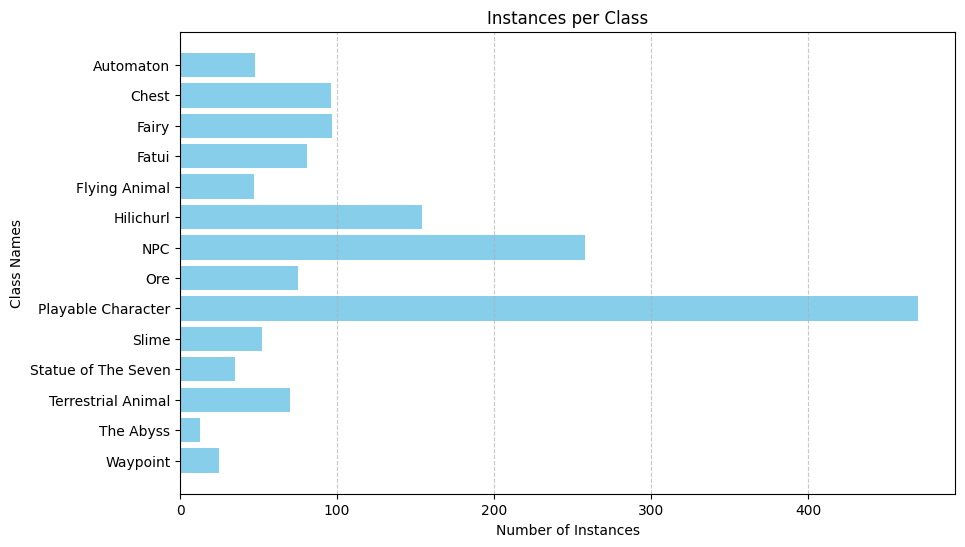

In [4]:
import os
import shutil
import yaml
import pandas as pd
from pathlib import Path
from collections import Counter
from sklearn.model_selection import train_test_split

# ========================== Load Dataset and YAML ==================================
dataset_path = Path(DATASET_PATH)
labels = sorted(dataset_path.rglob("labels/*.txt"))  # All label files

yaml_file = DATA_PATH
with open(yaml_file, encoding="utf8") as y:
    classes = yaml.safe_load(y)["names"]  # YOLO class names

cls_idx = list(range(len(classes)))  # Class indices

# ============== Create Feature Vectors (Number of classes per image) ===============
index = [label.stem for label in labels]  # Use filenames (without extension) as IDs
labels_df = pd.DataFrame([], columns=cls_idx, index=index)

for label in labels:
    lbl_counter = Counter()

    with open(label) as lf:
        lines = lf.readlines()

    for line in lines:
        lbl_counter[int(line.split(" ")[0])] += 1  # Extract YOLO class index

    labels_df.loc[label.stem] = lbl_counter

labels_df = labels_df.fillna(0).infer_objects(copy=False).astype(int)

import matplotlib.pyplot as plt

class_instances = labels_df.sum(axis=0)
class_names = [classes[idx] for idx in class_instances.index]

# Plot horizontal bar chart
plt.figure(figsize=(10, 6))
plt.barh(class_names, class_instances, color="skyblue")
plt.xlabel("Number of Instances")
plt.ylabel("Class Names")
plt.title("Instances per Class")
plt.gca().invert_yaxis()
plt.grid(axis="x", linestyle="--", alpha=0.7)
plt.show()

Now, we can split the dataset using these feature vectors
## Split

In [5]:
# ============================ Random Split ==================================
validation_size = 0.15
test_size = 0.10


train_files, temp_files = train_test_split(
    labels_df.index, test_size= validation_size + test_size, random_state=42
)

test_size = test_size / (validation_size + test_size)
val_files, test_files = train_test_split(
    temp_files, test_size=test_size, random_state=42
)

# ======================= Create output folder =============================
output_path = Path("split_dataset")
for split in ["train", "val", "test"]:
    (output_path / split / "images").mkdir(parents=True, exist_ok=True)
    (output_path / split / "labels").mkdir(parents=True, exist_ok=True)

def move_files(files, split):
    for file in files:
        src_img = dataset_path / f"images/{file}.png"
        src_lbl = dataset_path / f"labels/{file}.txt"

        dst_img = output_path / split / "images" / f"{file}.png"
        dst_lbl = output_path / split / "labels" / f"{file}.txt"

        if src_img.exists():
            shutil.copy(src_img, dst_img)
        if src_lbl.exists():
            shutil.copy(src_lbl, dst_lbl)

move_files(train_files, "train")
move_files(val_files, "val")
move_files(test_files, "test")

# ======================= Create data_split.yaml =============================
yaml_content = {
    "train": str(output_path / "train"),
    "val": str(output_path / "val"),
    "test": str(output_path / "test"),
    "nc": len(classes),
    "names": classes,
}

with open(output_path / "data_split.yaml", "w") as f:
    yaml.dump(yaml_content, f)

print("Dataset successfully split into train, val, and test with stratified distribution.")

Dataset successfully split into train, val, and test with stratified distribution.


## Split distributions

Is our split good ? Let's see that

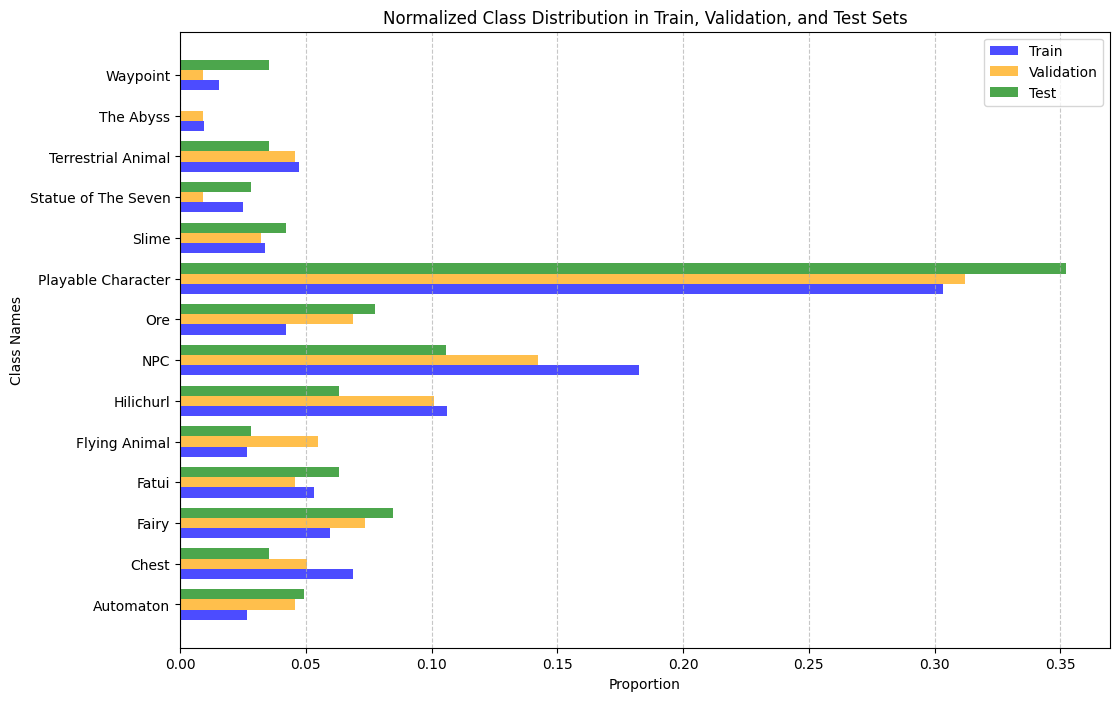

In [6]:
# ===================== Plot Split Distributions =====================
import numpy as np

# Function to compute class densities (proportions)
def compute_class_densities(file_list):
    subset_df = labels_df.loc[file_list]  # Filter dataset for the split
    class_counts = subset_df.sum(axis=0)  # Get total instances per class
    total_instances = class_counts.sum()  # Sum across all classes

    return class_counts / total_instances if total_instances > 0 else class_counts  # Normalize

# Compute densities for each split
train_densities = compute_class_densities(train_files)
val_densities = compute_class_densities(val_files)
test_densities = compute_class_densities(test_files)

# Create a horizontal bar chart with normalized densities
y = np.arange(len(classes))  # Class indices
width = 0.25  # Bar width

plt.figure(figsize=(12, 8))

# Plot the bars horizontally
plt.barh(y - width, train_densities, height=width, label="Train", color="blue", alpha=0.7)
plt.barh(y, val_densities, height=width, label="Validation", color="orange", alpha=0.7)
plt.barh(y + width, test_densities, height=width, label="Test", color="green", alpha=0.7)

# Add labels and title
plt.ylabel("Class Names")
plt.xlabel("Proportion")
plt.title("Normalized Class Distribution in Train, Validation, and Test Sets")
plt.yticks(ticks=y, labels=classes)  # Set class names on the y-axis
plt.legend()
plt.grid(axis="x", linestyle="--", alpha=0.7)

# Show the plot
plt.show()

# Old code for training

In [ ]:
!yolo detect train data=/content/data.yaml model=yolo11s.pt epochs=60 imgsz=640

Testing with the validation folder

In [ ]:
!yolo detect predict model=runs/detect/train/weights/best.pt source=data/validation/images save=True

In [ ]:
import glob
from IPython.display import Image, display
for image_path in glob.glob(f'/content/runs/detect/predict2/*.jpg')[:10]:
  display(Image(filename=image_path, height=400))
  print('\n')